In [1]:
from demodq.datasets import Datasets
from demodq.column_errors import detect_missing_values, detect_outliers_sd, detect_outliers_iqr
from demodq.tuple_errors import detect_mislabeled_via_cleanlab, detect_outliers_via_if, detect_mislabeled_via_shapley
from demodq.analysis import analyse_marked, detect_disparate_errors, is_disparate

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

def perc(frac):
    if frac == np.NAN: return frac
    return str(round(frac * 100, 1)) + '\%'

In [3]:
import pandas as pd

cases = [('adult', 'sex', 'race'), ('folktables', 'sex', 'race'),
         ('german', 'age', 'sex'), ('heart', 'sex', 'age@45')]

Set up streamlined workflow for SQL analysis with DuckDB. ([example notebook in Colab](https://colab.research.google.com/drive/1eOA2FYHqEfZWLYssbUxdIpSL3PFxWVjk?usp=sharing#scrollTo=vQivFMys2vtz))

In [4]:
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# Configure jupysql to return data as a Pandas dataframe and have less verbose output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Connect jupysql to in-memory DuckDB database
%sql duckdb:///:memory:

In [5]:
%%sql
CREATE TABLE groups(
    dataset VARCHAR,
    attr1 VARCHAR,
    attr2 VARCHAR,
    pp_count INTEGER,
    pd_count INTEGER,
    dp_count INTEGER,
    dd_count INTEGER,
    PRIMARY KEY(dataset, attr1, attr2));

CREATE TABLE errors(
    dataset VARCHAR,
    attr1 VARCHAR,
    attr2 VARCHAR,
    error_type VARCHAR,
    pp_dirty INTEGER,
    pd_dirty INTEGER,
    dp_dirty INTEGER,
    dd_dirty INTEGER,
    disparate BOOLEAN,
    PRIMARY KEY(dataset, attr1, attr2, error_type));

,Success


In [6]:
for dataset_name, attr1, attr2 in cases:
    dataset = Datasets.load(dataset_name)

    data = dataset.as_df().copy(deep=True)
    data['id'] = range(len(data))

    dirty_slices = []

    for column in dataset.categorical_columns + dataset.numerical_columns:
        dirty_slices.append(detect_missing_values(data, column))

    dirty = pd.concat(dirty_slices).drop_duplicates(subset='id')

    data_priv_priv, data_priv_nonpriv, data_nonpriv_priv, data_nonpriv_nonpriv = \
        dataset.partition_data_by_intersection(data, attr1, attr2)
    dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
        dataset.partition_data_by_intersection(dirty, attr1, attr2)

    query = f"INSERT INTO groups VALUES ('{dataset_name}', '{attr1}', '{attr2}', "\
            f"{len(data_priv_priv)}, {len(data_priv_nonpriv)}, "\
            f"{len(data_nonpriv_priv)}, {len(data_nonpriv_nonpriv)})"
    %sql {{query}}

    disparate = is_disparate(len(data_priv_priv), len(dirty_priv_priv), len(data_nonpriv_nonpriv), len(dirty_nonpriv_nonpriv))

    query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'missing-values',"\
            f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
            f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)}, {disparate})"
    %sql {{query}}

In [7]:
%sql SELECT * FROM groups

,dataset,attr1,attr2,pp_count,pd_count,dp_count,dd_count
0,adult,sex,race,28735,3915,13027,3165
1,folktables,sex,race,115136,71541,117473,74667
2,german,age,sex,605,205,85,105
3,heart,sex,age@45,39163,6367,20565,3905


In [8]:
%sql SELECT * FROM errors WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,pp_dirty,pd_dirty,dp_dirty,dd_dirty,disparate
0,adult,sex,race,missing-values,1715,408,1144,353,True
1,folktables,sex,race,missing-values,50027,32841,60974,38371,True
2,german,age,sex,missing-values,208,58,18,21,True
3,heart,sex,age@45,missing-values,0,0,0,0,False


In [9]:
%%sql --save group_error_rates --no-execute
SELECT
    e.dataset, e.attr1, e.attr2, e.error_type,

    IF(e.disparate, pp_dirty/pp_count, 0.0) AS pp_dirty__pp_count,
    pp_count,
    pp_count/total_count AS pp_count__total_count,
    pp_dirty/total_dirty AS pp_dirty__total_dirty,

    IF(e.disparate, pd_dirty/pd_count, 0.0) AS pd_dirty__pd_count,
    pd_count,
    pd_count/total_count AS pd_count__total_count,
    pd_dirty/total_dirty AS pd_dirty__total_dirty,

    IF(e.disparate, dp_dirty/dp_count, 0.0) AS dp_dirty__dp_count,
    dp_count,
    dp_count/total_count AS dp_count__total_count,
    dp_dirty/total_dirty AS dp_dirty__total_dirty,

    IF(e.disparate, dd_dirty/dd_count, 0.0) AS dd_dirty__dd_count,
    dd_count,
    dd_count/total_count AS dd_count__total_count,
    dd_dirty/total_dirty AS dd_dirty__total_dirty,

    IF(e.disparate, (pp_dirty + pd_dirty + dp_dirty) / (pp_count + pd_count + dp_count), 0.0) AS pagg_dirty__pagg_count,
    (pp_count + pd_count + dp_count) AS pagg_count,
    (pp_count + pd_count + dp_count) / total_count AS pagg_count__total_count,
    (pp_dirty + pd_dirty + dp_dirty) / total_dirty AS pagg_dirty__total_dirty,

    IF(e.disparate, (pd_dirty + dp_dirty + dd_dirty) / (pd_count + dp_count + dd_count), 0.0) AS dagg_dirty__dagg_count,
    (pd_count + dp_count + dd_count) AS dagg_count,
    (pd_count + dp_count + dd_count) / total_count AS dagg_count__total_count,
    (pd_dirty + dp_dirty + dd_dirty) / total_dirty AS dagg_dirty__total_dirty,
FROM (
    SELECT
        dataset, attr1, attr2, error_type, disparate,
        pp_dirty, pd_dirty, dp_dirty, dd_dirty,
        (pp_dirty + pd_dirty + dp_dirty + dd_dirty) AS total_dirty,
    FROM errors
) e
JOIN (
    SELECT
        dataset, attr1, attr2,
        pp_count, pd_count, dp_count, dd_count,
        (pp_count + pd_count + dp_count + dd_count) AS total_count,
    FROM groups
) g
ON g.dataset = e.dataset AND g.attr1 = e.attr1 AND g.attr2 = e.attr2

Skipping execution...

In [10]:
%%sql --save error_rates__pp_dd --with group_error_rates --no-execute
SELECT
    dataset, attr1, attr2, error_type,
    pp_dirty__pp_count AS priv_dirty__priv_count,
    pp_count AS priv_count,
    pp_count__total_count AS priv_count__total_count,
    pp_dirty__total_dirty AS priv_dirty__total_dirty,
    dd_dirty__dd_count AS dis_dirty__dis_count,
    dd_count AS dis_count,
    dd_count__total_count AS dis_count__total_count,
    dd_dirty__total_dirty AS dis_dirty__total_dirty,
FROM group_error_rates

Skipping execution...

In [11]:
%%sql --save error_rates__pagg_dd --with group_error_rates --no-execute
SELECT
    dataset, attr1, attr2, error_type,
    pagg_dirty__pagg_count AS priv_dirty__priv_count,
    pagg_count AS priv_count,
    pagg_count__total_count AS priv_count__total_count,
    pagg_dirty__total_dirty AS priv_dirty__total_dirty,
    dd_dirty__dd_count AS dis_dirty__dis_count,
    dd_count AS dis_count,
    dd_count__total_count AS dis_count__total_count,
    dd_dirty__total_dirty AS dis_dirty__total_dirty,
FROM group_error_rates

Skipping execution...

In [12]:
%%sql --save error_rates__pp_dagg --with group_error_rates --no-execute
SELECT
    dataset, attr1, attr2, error_type,
    pp_dirty__pp_count AS priv_dirty__priv_count,
    pagg_count AS priv_count,
    pagg_count__total_count AS priv_count__total_count,
    pagg_dirty__total_dirty AS priv_dirty__total_dirty,
    dagg_dirty__dagg_count AS dis_dirty__dis_count,
    dagg_count AS dis_count,
    dagg_count__total_count AS dis_count__total_count,
    dagg_dirty__total_dirty AS dis_dirty__total_dirty,
FROM group_error_rates

Skipping execution...

In [13]:
%%sql --save missing_values__pp_dd --with error_rates__pp_dd
SELECT *
FROM error_rates__pp_dd
WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,missing-values,0.059683,28735,0.588326,0.473757,0.111532,3165,0.064801,0.097514
1,folktables,sex,race,missing-values,0.434504,115136,0.303936,0.274552,0.513895,74667,0.197106,0.210583
2,german,age,sex,missing-values,0.343802,605,0.605000,0.681967,0.200000,105,0.105000,0.068852
3,heart,sex,age@45,missing-values,0.000000,39163,0.559471,NaN,0.000000,3905,0.055786,NaN


In [14]:
%%sql --save missing_values__pagg_dd --with error_rates__pagg_dd
SELECT *
FROM error_rates__pagg_dd
WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,missing-values,0.071524,45677,0.935199,0.902486,0.111532,3165,0.064801,0.097514
1,folktables,sex,race,missing-values,0.472931,304150,0.802894,0.789417,0.513895,74667,0.197106,0.210583
2,german,age,sex,missing-values,0.317318,895,0.895000,0.931148,0.200000,105,0.105000,0.068852
3,heart,sex,age@45,missing-values,0.000000,66095,0.944214,NaN,0.000000,3905,0.055786,NaN


In [15]:
%%sql --save missing_values__pp_dagg --with error_rates__pp_dagg
SELECT *
FROM error_rates__pp_dagg
WHERE error_type = 'missing-values'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,missing-values,0.059683,45677,0.935199,0.902486,0.094743,20107,0.411674,0.526243
1,folktables,sex,race,missing-values,0.434504,304150,0.802894,0.789417,0.501310,263681,0.696064,0.725448
2,german,age,sex,missing-values,0.343802,895,0.895000,0.931148,0.245570,395,0.395000,0.318033
3,heart,sex,age@45,missing-values,0.000000,66095,0.944214,NaN,0.000000,30837,0.440529,NaN


In [16]:
for dataset_name, attr1, attr2 in cases:
    dataset = Datasets.load(dataset_name)

    data = dataset.as_df().copy(deep=True)
    data['id'] = range(len(data))

    for detector, name in [(detect_outliers_sd, 'sd'), (detect_outliers_iqr, 'iqr')]:
        dirty_slices = []

        for column in dataset.numerical_columns:
            dirty_slices.append(detector(data, column))

        dirty = pd.concat(dirty_slices).drop_duplicates(subset='id')

        data_priv_priv, data_priv_nonpriv, data_nonpriv_priv, data_nonpriv_nonpriv = \
            dataset.partition_data_by_intersection(data, attr1, attr2)
        dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
            dataset.partition_data_by_intersection(dirty, attr1, attr2)

        disparate = is_disparate(len(data_priv_priv), len(dirty_priv_priv), len(data_nonpriv_nonpriv), len(dirty_nonpriv_nonpriv))

        query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'outliers-{name}',"\
                f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
                f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)}, {disparate})"
        %sql {{query}}

    # Isolation Forest
    dirty = detect_outliers_via_if(data, dataset, 1234)  # TODO: Try different seeds

    data_priv_priv, data_priv_nonpriv, data_nonpriv_priv, data_nonpriv_nonpriv = \
        dataset.partition_data_by_intersection(data, attr1, attr2)
    dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
        dataset.partition_data_by_intersection(dirty, attr1, attr2)

    disparate = is_disparate(len(data_priv_priv), len(dirty_priv_priv), len(data_nonpriv_nonpriv), len(dirty_nonpriv_nonpriv))

    query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'outliers-if',"\
            f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
            f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)}, {disparate})"
    %sql {{query}}

In [17]:
%%sql --save outliers__pp_dd --with error_rates__pp_dd
SELECT *
FROM error_rates__pp_dd
WHERE error_type LIKE 'outliers-%'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,outliers-sd,0.080773,28735,0.588326,0.694079,0.037599,3165,0.064801,0.035586
1,adult,sex,race,outliers-iqr,0.372159,28735,0.588326,0.587066,0.310269,3165,0.064801,0.053909
2,adult,sex,race,outliers-if,0.000557,28735,0.588326,0.032720,0.088784,3165,0.064801,0.574642
3,folktables,sex,race,outliers-sd,0.006957,115136,0.303936,0.424483,0.004179,74667,0.197106,0.165342
4,folktables,sex,race,outliers-iqr,0.000000,115136,0.303936,NaN,0.000000,74667,0.197106,NaN
5,folktables,sex,race,outliers-if,0.002597,115136,0.303936,0.078913,0.022272,74667,0.197106,0.438902
6,german,age,sex,outliers-sd,0.000000,605,0.605000,0.687500,0.000000,105,0.105000,0.041667
7,german,age,sex,outliers-iqr,0.345455,605,0.605000,0.768382,0.104762,105,0.105000,0.040441
8,german,age,sex,outliers-if,0.000000,605,0.605000,0.600000,0.000000,105,0.105000,0.100000
9,heart,sex,age@45,outliers-sd,0.108495,39163,0.559471,0.601586,0.068374,3905,0.055786,0.037803


In [18]:
%%sql --save outliers__pagg_dd --with error_rates__pagg_dd
SELECT *
FROM error_rates__pagg_dd
WHERE error_type LIKE 'outliers-%'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,outliers-sd,0.070604,45677,0.935199,0.964414,0.037599,3165,0.064801,0.035586
1,adult,sex,race,outliers-iqr,0.377301,45677,0.935199,0.946091,0.310269,3165,0.064801,0.053909
2,adult,sex,race,outliers-if,0.004554,45677,0.935199,0.425358,0.088784,3165,0.064801,0.574642
3,folktables,sex,race,outliers-sd,0.005178,304150,0.802894,0.834658,0.004179,74667,0.197106,0.165342
4,folktables,sex,race,outliers-iqr,0.000000,304150,0.802894,NaN,0.000000,74667,0.197106,NaN
5,folktables,sex,race,outliers-if,0.006990,304150,0.802894,0.561098,0.022272,74667,0.197106,0.438902
6,german,age,sex,outliers-sd,0.000000,895,0.895000,0.958333,0.000000,105,0.105000,0.041667
7,german,age,sex,outliers-iqr,0.291620,895,0.895000,0.959559,0.104762,105,0.105000,0.040441
8,german,age,sex,outliers-if,0.000000,895,0.895000,0.900000,0.000000,105,0.105000,0.100000
9,heart,sex,age@45,outliers-sd,0.102822,66095,0.944214,0.962197,0.068374,3905,0.055786,0.037803


In [19]:
%%sql --save outliers__pp_dagg --with error_rates__pp_dagg
SELECT *
FROM error_rates__pp_dagg
WHERE error_type LIKE 'outliers-%'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,outliers-sd,0.080773,45677,0.935199,0.964414,0.050878,20107,0.411674,0.305921
1,adult,sex,race,outliers-iqr,0.372159,45677,0.935199,0.946091,0.374099,20107,0.411674,0.412934
2,adult,sex,race,outliers-if,0.000557,45677,0.935199,0.425358,0.023524,20107,0.411674,0.967280
3,folktables,sex,race,outliers-sd,0.006957,304150,0.802894,0.834658,0.004119,263681,0.696064,0.575517
4,folktables,sex,race,outliers-iqr,0.000000,304150,0.802894,NaN,0.000000,263681,0.696064,NaN
5,folktables,sex,race,outliers-if,0.002597,304150,0.802894,0.561098,0.013236,263681,0.696064,0.921087
6,german,age,sex,outliers-sd,0.000000,895,0.895000,0.958333,0.000000,395,0.395000,0.312500
7,german,age,sex,outliers-iqr,0.345455,895,0.895000,0.959559,0.159494,395,0.395000,0.231618
8,german,age,sex,outliers-if,0.000000,895,0.895000,0.900000,0.000000,395,0.395000,0.400000
9,heart,sex,age@45,outliers-sd,0.108495,66095,0.944214,0.962197,0.091254,30837,0.440529,0.398414


In [20]:
for dataset_name, attr1, attr2 in cases:
    dataset = Datasets.load(dataset_name)

    data = dataset.as_df().copy(deep=True)
    data['id'] = range(len(data))

    for detector, name in [(detect_mislabeled_via_cleanlab, 'cl'), (detect_mislabeled_via_shapley, 'shap')]:
        dirty = detector(data, dataset, 1234)  # TODO: Try different seeds

        data_priv_priv, data_priv_nonpriv, data_nonpriv_priv, data_nonpriv_nonpriv = \
            dataset.partition_data_by_intersection(data, attr1, attr2)
        dirty_priv_priv, dirty_priv_nonpriv, dirty_nonpriv_priv, dirty_nonpriv_nonpriv = \
            dataset.partition_data_by_intersection(dirty, attr1, attr2)

        disparate = is_disparate(len(data_priv_priv), len(dirty_priv_priv), len(data_nonpriv_nonpriv), len(dirty_nonpriv_nonpriv))

        query = f"INSERT INTO errors VALUES ('{dataset_name}', '{attr1}', '{attr2}', 'mislabels-{name}',"\
                f"{len(dirty_priv_priv)}, {len(dirty_priv_nonpriv)},"\
                f"{len(dirty_nonpriv_priv)}, {len(dirty_nonpriv_nonpriv)}, {disparate})"
        %sql {{query}}

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [21]:
%%sql --save mislabels__pp_dd --with error_rates__pp_dd
SELECT *
FROM error_rates__pp_dd
WHERE error_type = 'mislabels-cl'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,mislabels-cl,0.098208,28735,0.588326,0.727507,0.038231,3165,0.064801,0.031194
1,folktables,sex,race,mislabels-cl,0.080887,115136,0.303936,0.364187,0.050317,74667,0.197106,0.146919
2,german,age,sex,mislabels-cl,0.000000,605,0.605000,0.578595,0.000000,105,0.105000,0.107023
3,heart,sex,age@45,mislabels-cl,0.232030,39163,0.559471,0.574690,0.204866,3905,0.055786,0.050594


In [22]:
%%sql --save mislabels__pagg_dd --with error_rates__pagg_dd
SELECT *
FROM error_rates__pagg_dd
WHERE error_type = 'mislabels-cl'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,mislabels-cl,0.082273,45677,0.935199,0.968806,0.038231,3165,0.064801,0.031194
1,folktables,sex,race,mislabels-cl,0.071724,304150,0.802894,0.853081,0.050317,74667,0.197106,0.146919
2,german,age,sex,mislabels-cl,0.000000,895,0.895000,0.892977,0.000000,105,0.105000,0.107023
3,heart,sex,age@45,mislabels-cl,0.227128,66095,0.944214,0.949406,0.204866,3905,0.055786,0.050594


In [23]:
%%sql --save mislabels__pp_dagg --with error_rates__pp_dagg
SELECT *
FROM error_rates__pp_dagg
WHERE error_type = 'mislabels-cl'

,dataset,attr1,attr2,error_type,priv_dirty__priv_count,priv_count,priv_count__total_count,priv_dirty__total_dirty,dis_dirty__dis_count,dis_count,dis_count__total_count,dis_dirty__total_dirty
0,adult,sex,race,mislabels-cl,0.098208,45677,0.935199,0.968806,0.052569,20107,0.411674,0.272493
1,folktables,sex,race,mislabels-cl,0.080887,304150,0.802894,0.853081,0.061662,263681,0.696064,0.635813
2,german,age,sex,mislabels-cl,0.000000,895,0.895000,0.892977,0.000000,395,0.395000,0.421405
3,heart,sex,age@45,mislabels-cl,0.232030,66095,0.944214,0.949406,0.218082,30837,0.440529,0.425310


In [24]:
groups_df = %sql SELECT * FROM groups
groups_df.to_csv("cleanml_groups.csv", index=False)

errors_df = %sql SELECT * FROM errors
errors_df.to_csv("cleanml_errors.csv", index=False)

group_error_rates_df = %sql SELECT * FROM group_error_rates
group_error_rates_df.to_csv("cleanml_group_error_rates.csv", index=False)

Generating CTE with stored snippets: 'group_error_rates'

# Generate figure

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'

In [26]:
def from_intersectional_formulation(intersectional_formulation):
    error_rates_q = f"""
    SELECT
        round(100*priv_dirty__priv_count, 1) AS priv_pct,
        priv_count,
        round(100*dis_dirty__dis_count, 1) AS dis_pct,
        dis_count,
    FROM error_rates__{intersectional_formulation}
    """

    legend = []
    if intersectional_formulation == "pp_dd":
        legend = ["int. priv", "int. dis"]
    elif intersectional_formulation == "pagg_dd":
        legend = ["all others", "int. dis"]
    elif intersectional_formulation == "pp_dagg":
        legend = ["int. priv", "all others"]
        
    return error_rates_q, legend

In [27]:
def show_plot(intersectional_formulation, age_threshold):
    error_rates_q, legend = from_intersectional_formulation(intersectional_formulation)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

    xs = np.arange(len(cases))

    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_xticks(xs)
        ax.set_xticklabels(['adult/sex+race',
                            'folk/sex+race',
                            'german/age+sex',
                            'heart/sex+age'], rotation=90)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.set_ylim((0, 90))
        ax.set_xlim((-0.5, -0.5 + len(cases)))

        if ax != ax1:
            ax.get_yaxis().set_visible(False)

    color_priv = '#E9D5CA'
    color_dis = '#4D4C7D'

    # --- missing values
    # heart age@35, age@45, age@55 all have no missing values
    if age_threshold == "age@45":
        missing_values_df = %sql {{error_rates_q}} WHERE error_type = 'missing-values' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        missing_values_df = %sql {{error_rates_q}} WHERE error_type = 'missing-values' AND attr2 != 'age@45'
    ax1.bar(xs - 0.15, missing_values_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax1.bar(xs + 0.15, missing_values_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax1.set_title('missing values', fontsize=20)
    ax1.set_yticks([10, 20, 30, 40, 50, 60])
    ax1.set_ylabel('fraction of flagged\ntuples per group [\%]', fontsize=22)
    ax1.legend(legend, fontsize=16)

    xpos = -0.3
    for _, row in missing_values_df.iterrows():
        priv_pct, priv_count, dis_pct, dis_count = row.tolist()
        # lower, higher = sorted([priv_pct, dis_pct])
        # ypos = higher+2
        # ax1.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        # ax1.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        ax1.text(xpos, priv_pct + 5, str(int(priv_count)), fontsize=16, rotation=90)
        ax1.text(xpos + 0.35, dis_pct + 5, str(int(dis_count)), fontsize=16, rotation=90)
        xpos += 1

    # --- outliers-sd
    if age_threshold == "age@45":
        outliers_sd_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-sd' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        outliers_sd_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-sd' AND attr2 != 'age@45'
    ax2.bar(xs - 0.15, outliers_sd_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax2.bar(xs + 0.15, outliers_sd_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax2.set_title('outliers-sd\n(standard deviations)', fontsize=20)
    ax2.legend(legend, fontsize=16)

    xpos = -0.3
    for _, row in outliers_sd_df.iterrows():
        priv_pct, priv_count, dis_pct, dis_count = row.tolist()
        # lower, higher = sorted([priv_pct, dis_pct])
        # ypos = higher+2
        # ax2.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        # ax2.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        ax2.text(xpos, priv_pct + 5, str(int(priv_count)), fontsize=16, rotation=90)
        ax2.text(xpos + 0.35, dis_pct + 5, str(int(dis_count)), fontsize=16, rotation=90)
        xpos += 1

    # --- outliers-iqr
    if age_threshold == "age@45":
        outliers_iqr_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-iqr' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        outliers_iqr_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-iqr' AND attr2 != 'age@45'
    ax3.bar(xs - 0.15, outliers_iqr_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax3.bar(xs + 0.15, outliers_iqr_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax3.set_title('outliers-iqr\n(inter-quartile range)', fontsize=20)
    ax3.set_xlabel('dataset \& sensitive attribute', fontsize=22)
    ax3.legend(legend, fontsize=16)

    xpos = -0.3
    for _, row in outliers_iqr_df.iterrows():
        priv_pct, priv_count, dis_pct, dis_count = row.tolist()
        # lower, higher = sorted([priv_val, dis_val])
        # ypos = higher+2
        # ax3.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        # ax3.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        ax3.text(xpos, priv_pct + 5, str(int(priv_count)), fontsize=16, rotation=90)
        ax3.text(xpos + 0.35, dis_pct + 5, str(int(dis_count)), fontsize=16, rotation=90)
        xpos += 1

    # --- outliers-if
    if age_threshold == "age@45":
        outliers_if_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-if' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        outliers_if_df = %sql {{error_rates_q}} WHERE error_type = 'outliers-if' AND attr2 != 'age@45'
    ax4.bar(xs - 0.15, outliers_if_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax4.bar(xs + 0.15, outliers_if_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax4.set_title('outliers-if\n(isolation forest)', fontsize=20)
    ax4.legend(legend, fontsize=16)

    xpos = -0.3
    for _, row in outliers_if_df.iterrows():
        priv_pct, priv_count, dis_pct, dis_count = row.tolist()
        # lower, higher = sorted([priv_val, dis_val])
        # ypos = higher+2
        # ax4.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        # ax4.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        ax4.text(xpos, priv_pct + 5, str(int(priv_count)), fontsize=16, rotation=90)
        ax4.text(xpos + 0.35, dis_pct + 5, str(int(dis_count)), fontsize=16, rotation=90)
        xpos += 1

    # --- mislabels-cl
    if age_threshold == "age@45":
        mislabels_cl_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-cl' AND attr2 != 'age@55'
    elif age_threshold == "age@55":
        mislabels_cl_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-cl' AND attr2 != 'age@45'
    ax5.bar(xs - 0.15, mislabels_cl_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    ax5.bar(xs + 0.15, mislabels_cl_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    ax5.set_title('label errors', fontsize=20)
    ax5.legend(legend, fontsize=16)

    xpos = -0.3
    for _, row in mislabels_cl_df.iterrows():
        priv_pct, priv_count, dis_pct, dis_count = row.tolist()
        # lower, higher = sorted([priv_val, dis_val])
        # ypos = higher+2
        # ax5.text(xpos, ypos, str(int(lower))+"\%", fontsize=16)
        # ax5.text(xpos, ypos+8, str(int(higher))+"\%", fontsize=16)
        ax5.text(xpos, priv_pct + 5, str(int(priv_count)), fontsize=16, rotation=90)
        ax5.text(xpos + 0.35, dis_pct + 5, str(int(dis_count)), fontsize=16, rotation=90)
        xpos += 1

    # --- mislabels-shap
    # if age_threshold == "age@45":
    #     mislabels_shap_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-shap' AND attr2 != 'age@55'
    # elif age_threshold == "age@55":
    #     mislabels_shap_df = %sql {{error_rates_q}} WHERE error_type = 'mislabels-shap' AND attr2 != 'age@45'
    # ax5.bar(xs - 0.15, mislabels_shap_df.priv_pct.tolist(), width=0.3, edgecolor='black', color=color_priv)
    # ax5.bar(xs + 0.15, mislabels_shap_df.dis_pct.tolist(), width=0.3, edgecolor='black', color=color_dis)
    # ax5.set_title('label errors', fontsize=20)
    # ax5.legend(legend, fontsize=16)

    width, height = 16, 6
    fig.set_size_inches(width, height)
    plt.tight_layout()

    os.makedirs("figure")
    filename = os.path.join("figure", f"flagged-{intersectional_formulation}-{age_threshold}-{width}x{height}.pdf")
    print(filename)
    plt.gcf().savefig(filename, dpi=300)
    plt.show()

In [28]:
QUERY = """
SELECT
    dataset, attr1, attr2, error_type,
    round(100*priv_dirty__priv_count, 1) AS priv_pct,
    priv_count,
    round(100*dis_dirty__dis_count, 1) AS dis_pct,
    dis_count,
FROM (
    SELECT
        dataset, attr1, attr2, error_type,
        pp_dirty__pp_count AS priv_dirty__priv_count,
        pp_count AS priv_count,
        pp_count__total_count AS priv_count__total_count,
        pp_dirty__total_dirty AS priv_dirty__total_dirty,
        dd_dirty__dd_count AS dis_dirty__dis_count,
        dd_count AS dis_count,
        dd_count__total_count AS dis_count__total_count,
        dd_dirty__total_dirty AS dis_dirty__total_dirty,
    FROM (
        SELECT
            e.dataset, e.attr1, e.attr2, e.error_type,

            IF(e.disparate, pp_dirty/pp_count, 0.0) AS pp_dirty__pp_count,
            pp_count,
            pp_count/total_count AS pp_count__total_count,
            pp_dirty/total_dirty AS pp_dirty__total_dirty,

            IF(e.disparate, pd_dirty/pd_count, 0.0) AS pd_dirty__pd_count,
            pd_count,
            pd_count/total_count AS pd_count__total_count,
            pd_dirty/total_dirty AS pd_dirty__total_dirty,

            IF(e.disparate, dp_dirty/dp_count, 0.0) AS dp_dirty__dp_count,
            dp_count,
            dp_count/total_count AS dp_count__total_count,
            dp_dirty/total_dirty AS dp_dirty__total_dirty,

            IF(e.disparate, dd_dirty/dd_count, 0.0) AS dd_dirty__dd_count,
            dd_count,
            dd_count/total_count AS dd_count__total_count,
            dd_dirty/total_dirty AS dd_dirty__total_dirty,

            IF(e.disparate, (pp_dirty + pd_dirty + dp_dirty) / (pp_count + pd_count + dp_count), 0.0) AS pagg_dirty__pagg_count,
            (pp_count + pd_count + dp_count) AS pagg_count,
            (pp_count + pd_count + dp_count) / total_count AS pagg_count__total_count,
            (pp_dirty + pd_dirty + dp_dirty) / total_dirty AS pagg_dirty__total_dirty,

            IF(e.disparate, (pd_dirty + dp_dirty + dd_dirty) / (pd_count + dp_count + dd_count), 0.0) AS dagg_dirty__dagg_count,
            (pd_count + dp_count + dd_count) AS dagg_count,
            (pd_count + dp_count + dd_count) / total_count AS dagg_count__total_count,
            (pd_dirty + dp_dirty + dd_dirty) / total_dirty AS dagg_dirty__total_dirty,
        FROM (
            SELECT
                dataset, attr1, attr2, error_type, disparate,
                pp_dirty, pd_dirty, dp_dirty, dd_dirty,
                (pp_dirty + pd_dirty + dp_dirty + dd_dirty) AS total_dirty,
            FROM errors
        ) e
        JOIN (
            SELECT
                dataset, attr1, attr2,
                pp_count, pd_count, dp_count, dd_count,
                (pp_count + pd_count + dp_count + dd_count) AS total_count,
            FROM groups
        ) g
        ON g.dataset = e.dataset AND g.attr1 = e.attr1 AND g.attr2 = e.attr2
    )
)
WHERE error_type = 'missing-values' AND attr2 != 'age@55'
"""
missing_values_df = %sql {{QUERY}}
display(missing_values_df)

,dataset,attr1,attr2,error_type,priv_pct,priv_count,dis_pct,dis_count
0,adult,sex,race,missing-values,6.0,28735,11.2,3165
1,folktables,sex,race,missing-values,43.5,115136,51.4,74667
2,german,age,sex,missing-values,34.4,605,20.0,105
3,heart,sex,age@45,missing-values,0.0,39163,0.0,3905


Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

figure/flagged-pp_dd-age@45-16x6.pdf


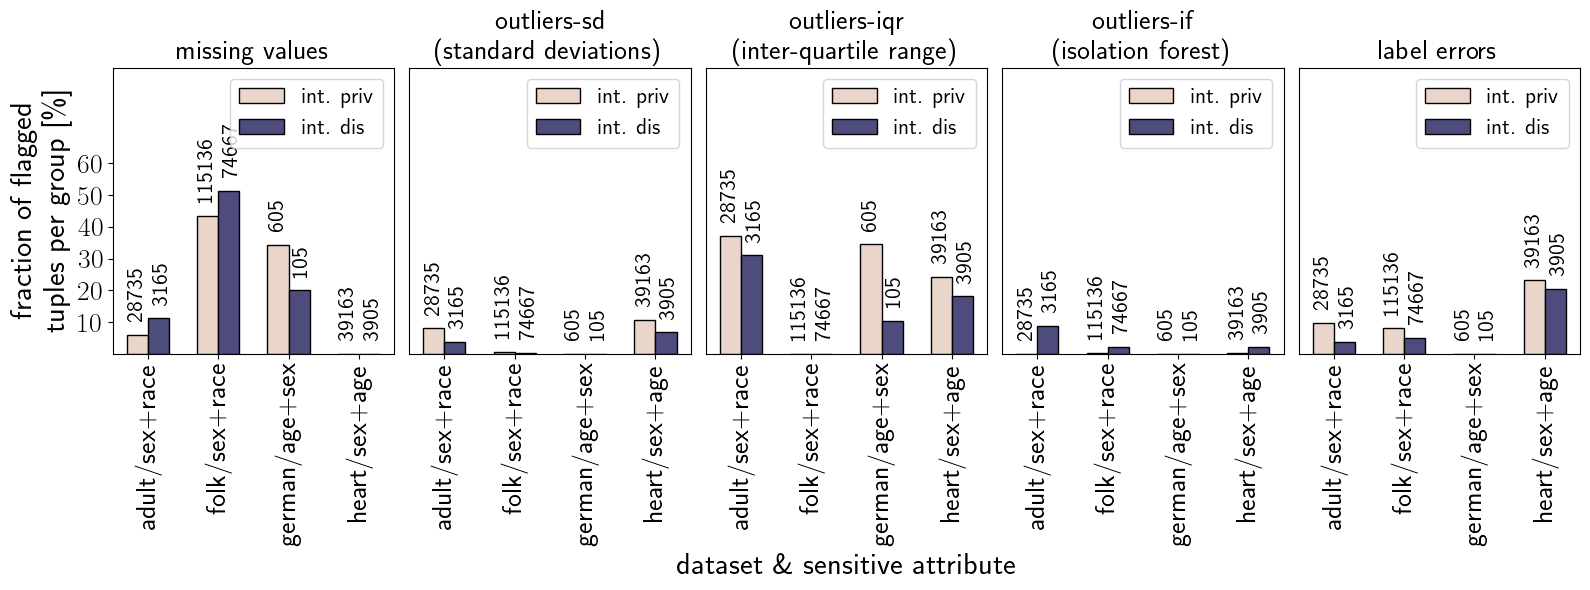

In [29]:
show_plot("pp_dd", "age@45")

Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

Generating CTE with stored snippets: 'error_rates__pp_dd'

FileExistsError: [Errno 17] File exists: 'figure'

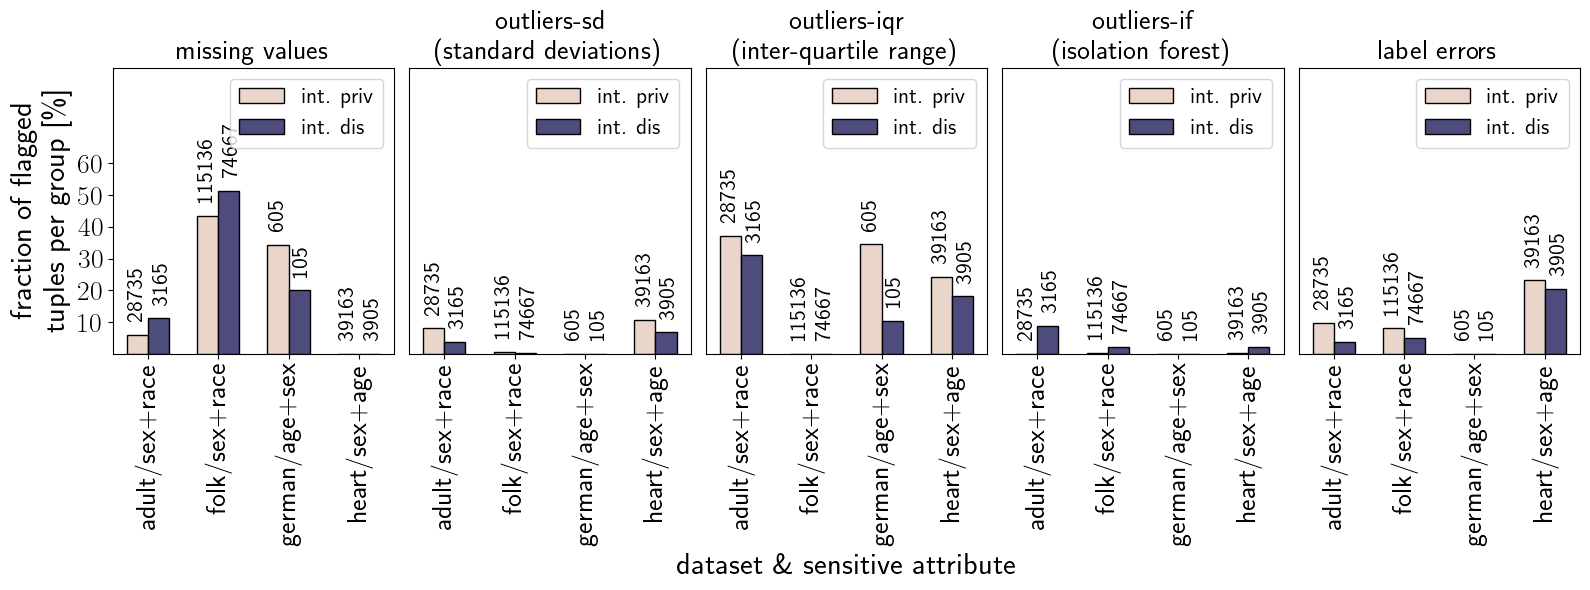

In [30]:
# intersectional_formulation = "pp_dd"    # pp vs. dd
# intersectional_formulation = "pagg_dd"  # pagg (all) vs. dd
# intersectional_formulation = "pp_dagg"  # pp vs. dagg (all)

# HEART AGE THRESHOLD
# age_threshold = "age@45"
# age_threshold = "age@55"

for intersectional_formulation in ["pp_dd", "pagg_dd", "pp_dagg"]:
    # for age_threshold in ["age@45", "age@55"]:  # Removed from `cases`
    show_plot(intersectional_formulation, "age@45")